In [1]:
!pip install --quiet scikit-learn

In [2]:
%cd ..

/Users/danorel/Workspace/Education/University/NYU/Research/xeda


In [3]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('.env'))

True

In [4]:
import random
import chromadb
import copy
import json
import typing as t
import pandas as pd
import numpy as np
import uuid
import pathlib
import s3fs
import openai
import traceback

from dagster import EnvVar
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from tqdm import tqdm

from constants import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_ENDPOINT_URL,
    AWS_S3_REGION_NAME,
    AWS_S3_BUCKET_NAME,
    AWS_S3_USE_SSL,
    GROUPS_CSV_PATH,
    OPENAI_API_KEY,
    OPENAI_EMBEDDINGS_MODEL,
    VECTOR_STORE_COLLECTION,
    VECTOR_STORE_HOST,
    VECTOR_STORE_PORT,
    UNIVERSAL_POLICY_NAME
)
from typings.pipeline import Pipeline, PipelineEda4Sum
from pipeline.resources import S3FSResource
from pipeline.solid.pipeline_annotator import annotate_pipeline
from pipeline.solid.utils.model_manager import ModelManager
from pipeline.solid.utils.pipelines.pipeline_precalculated_sets import PipelineWithPrecalculatedSets
from typings.pipeline import OperatorRequestData
from utils.s3 import pull_keras_model
from utils.vector_store import ChromaDBVectorStore, MilvusVectorStore, SearchResult, make_document_sampler

2024-05-07 13:37:59.372607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparing dataset

In [5]:
embedding_client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [6]:
vector_store = MilvusVectorStore(
    host=VECTOR_STORE_HOST, 
    port=VECTOR_STORE_PORT,
    collection_name=VECTOR_STORE_COLLECTION
)

In [7]:
fs = s3fs.S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_ACCESS_KEY,
    endpoint_url=AWS_S3_ENDPOINT_URL,
    use_ssl=AWS_S3_USE_SSL,
    client_kwargs={"region_name": AWS_S3_REGION_NAME},
)

In [8]:
database_pipeline_cache = {}
database_pipeline_cache["galaxies"] = PipelineWithPrecalculatedSets(
    "sdss",
    ["galaxies"],
    discrete_categories_count=10,
    min_set_size=10,
    exploration_columns=[
        "galaxies.u",
        "galaxies.g",
        "galaxies.r",
        "galaxies.i",
        "galaxies.z",
        "galaxies.petroRad_r",
        "galaxies.redshift",
    ],
    id_column="galaxies.objID",
)

In [9]:
model_manager = ModelManager(database_pipeline_cache["galaxies"], models = {
    "set": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="set_actor",
    ),
    "operation": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="operation_actor",
    ),
    "set_op_counters": None,
})

In [10]:
groups_df = pd.read_csv(GROUPS_CSV_PATH)

In [11]:
def make_embedding(text):
    response = embedding_client.embeddings.create(
        input=text,
        model=OPENAI_EMBEDDINGS_MODEL
    )
    return response.data[0].embedding

In [12]:
def node_to_annotation_encoding(node):
    annotation = node["annotation"]
    node_encoding = []
    for k, v in annotation.items():
        if isinstance(v, dict):
            for key in v:
                node_encoding.append(f"{k}_{key} = {v[key]}")
        else:
            node_encoding.append(f"{k} = {v}")
    return ', '.join(node_encoding)

def annotation_subset_to_embedding(annotation_subset: t.List[str]):
    annotation_text = ';'.join(annotation_subset)
    annotation_embedding = make_embedding(annotation_text)
    return annotation_embedding

def pipeline_to_annotation_subsets(pipeline: Pipeline) -> t.List[Pipeline]:
    annotation_subsets = []
    partial_annotation = []
    for node in reversed(pipeline):
        encoded_annotation = node_to_annotation_encoding(node)
        partial_annotation.append(encoded_annotation)
        annotation_subsets.append(copy.deepcopy(partial_annotation))
    return annotation_subsets

def pipeline_to_annotation_payloads(pipeline: Pipeline):
    annotation_subsets = pipeline_to_annotation_subsets(pipeline)
    annotation_payloads = (
        [str(uuid.uuid4()) for _ in range(len(annotation_subsets))],
        [annotation_subset_to_embedding(annotation_subset) for annotation_subset in annotation_subsets]
    )
    return annotation_payloads

def pipeline_to_encoding(annotated_pipeline: PipelineEda4Sum):
    return ';'.join([node_to_annotation_encoding(node) for node in annotated_pipeline])

def pipeline_to_embedding(pipeline: PipelineEda4Sum):
    annotated_pipeline = annotate_pipeline(groups_df, pipeline)
    pipeline_encoding = pipeline_to_encoding(annotated_pipeline)
    pipeline_embedding = make_embedding(pipeline_encoding)
    return pipeline_embedding

In [13]:
def fetch_pipelines():
    for annotated_file in fs.glob('xeda/annotated_pipelines/*.json'):
        with fs.open(annotated_file, 'r') as f:
            annotated_pipeline = json.load(f)
            if not isinstance(annotated_pipeline, list) or not len(annotated_pipeline):
                continue
            serialized_pipeline = json.dumps(annotated_pipeline)
            if len(serialized_pipeline) > 65535:
                continue
            yield annotated_pipeline, serialized_pipeline

def insert_pipelines(vector_store, refresh: bool = True):
    if not refresh:
        print("Skipping refresh of vector storage")
        return
    for annotated_pipeline, serialized_pipeline in tqdm(fetch_pipelines()):
        (
            annotation_ids,
            annotation_embeddings
        ) = pipeline_to_annotation_payloads(annotated_pipeline)
        if len(annotation_ids) > 0:
            vector_store.insert(
                ids=annotation_ids,
                documents=[serialized_pipeline for _ in range(len(annotation_ids))],
                embeddings=annotation_embeddings,
            )

insert_pipelines(vector_store, refresh=False)

Skipping refresh of vector storage


### Experiments

In [14]:
from concurrent.futures import ThreadPoolExecutor

def result_to_pipeline(result: SearchResult):
    try:
        return json.loads(result.get('document'))
    except:
        return {}

def result_to_id(result: SearchResult):
    try:
        return result.get('id')
    except:
        return None

def revert_pipeline(pipeline, k: int):
    return pipeline[:-k]

def lookup_metric(rank, k):
    """
    Calculate the similarity score based on the rank of the target in the k-nearest neighbors.
    
    Parameters:
    - rank: int, the rank (1-based) of the target in the search results. If the target is not found, this should be None or a value greater than k.
    - k: int, the number of nearest neighbors considered in the search.
    
    Returns:
    - float, the similarity score, ranging from 1 (best) to 0 (not found).
    """
    if rank is None or rank > k:
        return 0
    else:
        return (k - rank + 1) / k

def make_experiment(vector_store, terminal_pipeline, terminal_pipeline_id, exploration_steps: int):
    print(f"Starting an experiment with exploration_steps='{exploration_steps}'")
    start_time = time()

    terminal_embedding = pipeline_to_embedding(terminal_pipeline)
    
    partial_pipeline = revert_pipeline(terminal_pipeline, k=exploration_steps)
    partial_embedding = pipeline_to_embedding(partial_pipeline)
    
    partial_search_results = vector_store.search(embedding=partial_embedding, k=1000)
    neighbours_pipeline_ids = [result_to_id(result) for result in partial_search_results]

    exploration_lookup = len(neighbours_pipeline_ids)
    within_lookup = terminal_pipeline_id in neighbours_pipeline_ids
    try:
        lookup_rank = int(neighbours_pipeline_ids.index(terminal_pipeline_id))
    except:
        lookup_rank = None
    lookup_score = lookup_metric(lookup_rank, exploration_lookup)

    print(f"Finished an experiment with  exploration_steps='{exploration_steps}' and exploration_lookup='{exploration_lookup}' in {time() - start_time}s")
    
    return {
        "terminal_pipeline_id": terminal_pipeline_id,
        "within_lookup": within_lookup,
        "lookup_rank": lookup_rank,
        "lookup_score": lookup_score,
        "exploration_lookup": exploration_lookup
    }

def experiment_metadata(experiment, exploration_steps: int):
    r = {
        "experiment": experiment + 1,
        "exploration_steps": exploration_steps,
    }
    return r

def run_single_experiment(args):
    try:
        experiment, vector_store, terminal_pipeline, terminal_pipeline_id, explorations_steps = args
        results = []
        for exploration_steps in range(*explorations_steps):
            experiment_config = (exploration_steps,)
            results.append({
                **experiment_metadata(
                    experiment,
                    *experiment_config
                ),
                **make_experiment(
                    vector_store,
                    terminal_pipeline,
                    terminal_pipeline_id,
                    *experiment_config
                )
            })
        return results
    except Exception as e:
        print(f"Error in experiment {args[0]}: {e}")  # Log the error and experiment details
        print(traceback.format_exc())
        return []  # Return an empty list or some error indicator


def run_experiments(n: int = 1000, explorations_steps: tuple = (3, 6), max_workers: int = 1):
    pipeline_sampler = make_document_sampler(vector_store)

    # Prepare arguments for each experiment
    experiments_args = []
    for experiment in range(n):
        sampled_pipeline = None
        while sampled_pipeline is None:
            sampled_pipeline_index, sampled_pipeline_id = pipeline_sampler()
            try:
                sampled_pipeline = result_to_pipeline(vector_store.get(sampled_pipeline_id))
            except Exception as e:
                print(f"Failed to parse Pipeline[id={sampled_pipeline_id}]")
        experiments_args.append((experiment, vector_store, sampled_pipeline, sampled_pipeline_id, explorations_steps))
    
    # Run experiments in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(run_single_experiment, experiments_args), total=n))
    
    # Collect all results into a single DataFrame
    experiments = pd.DataFrame([item for sublist in results for item in sublist])
    return experiments

In [15]:
experiments_path = 'data/evaluation_experiments_1000_k-1-4.csv'

if pathlib.Path(experiments_path).exists():
    experiments_df = pd.read_csv(experiments_path)
else:
    experiments_df = run_experiments(
        n=1000,
        explorations_steps=(1, 5)
    )

In [16]:
experiments_df.to_csv(experiments_path, index=False)

### Visualizations

In [17]:
!pip install --quiet matplotlib seaborn

In [18]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [19]:
visualization_df = experiments_df.copy()

In [20]:
visualization_df

,experiment,exploration_steps,terminal_pipeline_id,within_lookup,lookup_rank,lookup_score,exploration_lookup
0,1,1,35ac3fb5-70b9-447e-b0ff-0e60fb771db6,True,146.0,0.500000,290
1,1,2,35ac3fb5-70b9-447e-b0ff-0e60fb771db6,True,143.0,0.510345,290
2,1,3,35ac3fb5-70b9-447e-b0ff-0e60fb771db6,True,142.0,0.397436,234
3,1,4,35ac3fb5-70b9-447e-b0ff-0e60fb771db6,True,141.0,0.401709,234
4,2,1,bdc1327f-46dc-42ab-88fb-f16c40e0c0ec,False,NaN,0.000000,229
...,...,...,...,...,...,...,...
3995,999,4,b6b5c8c1-7e2f-4310-adcb-a900aca857fe,False,NaN,0.000000,356
3996,1000,1,b6fc81f2-4c28-4ed8-b022-3d49615e4568,False,NaN,0.000000,260
3997,1000,2,b6fc81f2-4c28-4ed8-b022-3d49615e4568,False,NaN,0.000000,264
3998,1000,3,b6fc81f2-4c28-4ed8-b022-3d49615e4568,False,NaN,0.000000,232


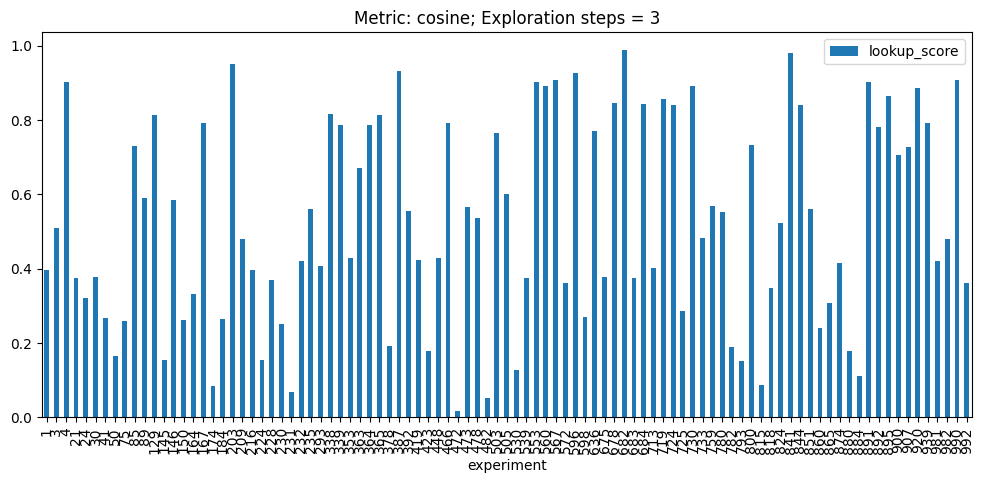

In [21]:
exploration_steps_3_df = visualization_df.loc[
    (visualization_df['exploration_steps'] == 3) &
    (visualization_df['within_lookup'] == True)
][['experiment', 'lookup_score', 'lookup_rank']]

plot = exploration_steps_3_df.plot(
    kind='bar',
    x='experiment', 
    y='lookup_score',
    title='Metric: cosine; Exploration steps = 3',
    figsize=(12, 5)
)
plt.show()